#**Artificial Neural Network (ANN)**

***Prepared by:*** [**Manisa Pipattanasomporn**](https://mpipatta.github.io)

*Created: January 2, 2020 (updated March 6, 2020)*

LSTM is a deep learning family. In this tutorial, we will use LSTM to perform hour-ahead load forecasting when historical load data are inputs to the forecasting model.

We will use keras library.




---


#**Step 1: Load Data**

Again, this notebook will work with "Bangkok.csv", the electrical consumption of a building at one-hour intervals for one year.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler

np.random.seed(7)

Using TensorFlow backend.


In [2]:
url ='https://raw.githubusercontent.com/mpipatta/mpipatta.github.io/master/testdata/Bangkok.csv'
df = pd.read_csv(url, index_col=[0], parse_dates=[0])[['Load','Outdoor']]
df.head(5)
#We will parse the first column (col=[0]) as the index column as the date. 
#The 'Load' column will be saved in the dataframe df.
#Note: the 'Load' is in kilo-Watt (kW).

,Load,Outdoor
Time,,
2016-01-01 00:00:00,4.30,80.5
2016-01-01 01:00:00,4.12,79.2
2016-01-01 02:00:00,4.06,79.1
2016-01-01 03:00:00,4.44,79.0
2016-01-01 04:00:00,3.88,78.8


In [3]:
df['Lt-1'] = df['Load'].shift(1)
df['W']=df.index.dayofweek
df['H']=df.index.hour
df.head()

,Load,Outdoor,Lt-1,W,H
Time,,,,,
2016-01-01 00:00:00,4.30,80.5,NaN,4,0
2016-01-01 01:00:00,4.12,79.2,4.30,4,1
2016-01-01 02:00:00,4.06,79.1,4.12,4,2
2016-01-01 03:00:00,4.44,79.0,4.06,4,3
2016-01-01 04:00:00,3.88,78.8,4.44,4,4


In [4]:
import datetime
df['holiday'] = ((df.index.date == datetime.date(2016, 1, 1) )| #New Year
                 (df.index.date == datetime.date(2016, 4, 6) )| #Chakri Momorial Day
                 (df.index.date == datetime.date(2016, 4, 13))| #Songkran
                 (df.index.date == datetime.date(2016, 4, 14))| #Songkran
                 (df.index.date == datetime.date(2016, 4, 15))| #Songkran
                 (df.index.date == datetime.date(2016, 5, 2) )| #Labor 
                 (df.index.date == datetime.date(2016, 5, 5) )| #Coronation
                 (df.index.date == datetime.date(2016, 5, 6) )| #Coronation
                 (df.index.date == datetime.date(2016, 5, 9) )| #Royal Ploudhing
                 (df.index.date == datetime.date(2016, 5, 20))| #Vesak
                 (df.index.date == datetime.date(2016, 7, 18))| #Asalha Puja
                 (df.index.date == datetime.date(2016, 7, 19))| #Asalha Puja
                 (df.index.date == datetime.date(2016, 8, 12))| #Queen's Birthday
                 (df.index.date == datetime.date(2016, 10,14))| #King's 
                 (df.index.date == datetime.date(2016, 10,24))| #CU Memorial Day 
                 (df.index.date == datetime.date(2016, 12, 5))| #King's Birthday 
                 (df.index.date == datetime.date(2016, 12,12)) #Constitution Day
                 )
df.head()

,Load,Outdoor,Lt-1,W,H,holiday
Time,,,,,,
2016-01-01 00:00:00,4.30,80.5,NaN,4,0,True
2016-01-01 01:00:00,4.12,79.2,4.30,4,1,True
2016-01-01 02:00:00,4.06,79.1,4.12,4,2,True
2016-01-01 03:00:00,4.44,79.0,4.06,4,3,True
2016-01-01 04:00:00,3.88,78.8,4.44,4,4,True


In [5]:
df.loc[df['holiday']==True,'W'] = 6
df.head()

,Load,Outdoor,Lt-1,W,H,holiday
Time,,,,,,
2016-01-01 00:00:00,4.30,80.5,NaN,6,0,True
2016-01-01 01:00:00,4.12,79.2,4.30,6,1,True
2016-01-01 02:00:00,4.06,79.1,4.12,6,2,True
2016-01-01 03:00:00,4.44,79.0,4.06,6,3,True
2016-01-01 04:00:00,3.88,78.8,4.44,6,4,True


In [0]:
Lt  = np.array(df['Load'].values).reshape(-1,1)
Lt1 = np.array(df['Lt-1'].values).reshape(-1,1)
T = np.array(df['Outdoor'].values).reshape(-1,1)
W = np.array(df['W'].values).reshape(-1,1)
H = np.array(df['H'].values).reshape(-1,1)

Text(0.5, 0, 'Time (hour)')

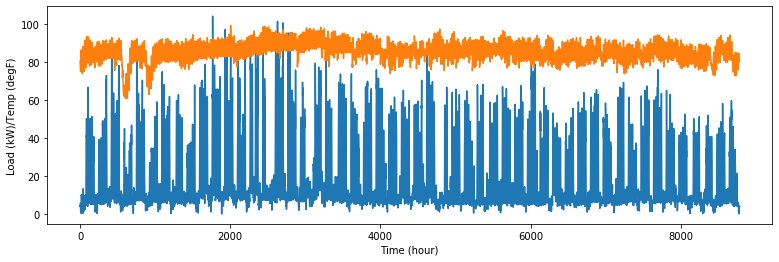

In [7]:
plt.figure(figsize=(13,4))
plt.plot(Lt)
plt.plot(T)
plt.ylabel('Load (kW)/Temp (degF)')
plt.xlabel('Time (hour)')

#**Step 2: Prepare Data**

### **a) Normalize the dataset**

Text(0.5, 0, 'Time (hour)')

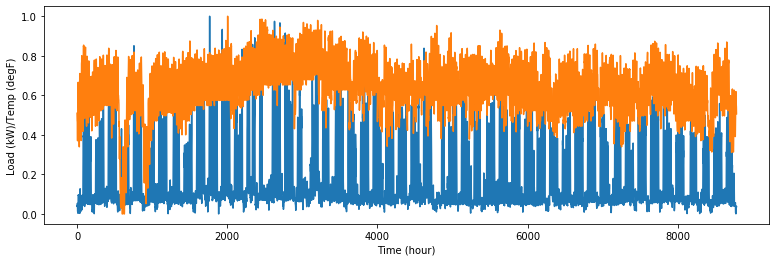

In [8]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
Lt = scaler.fit_transform(Lt)


Lt1 = scaler.fit_transform(Lt1)
scaler2 = MinMaxScaler(feature_range=(0, 1))
T = scaler2.fit_transform(T)
scaler3 = MinMaxScaler(feature_range=(0, 1))
W = scaler3.fit_transform(W)
scaler4 = MinMaxScaler(feature_range=(0, 1))
H = scaler4.fit_transform(H)

plt.figure(figsize=(13,4))
plt.plot(Lt)
plt.plot(T)
plt.ylabel('Load (kW)/Temp (degF)')
plt.xlabel('Time (hour)')

Text(0.5, 0, 'Time (hour)')

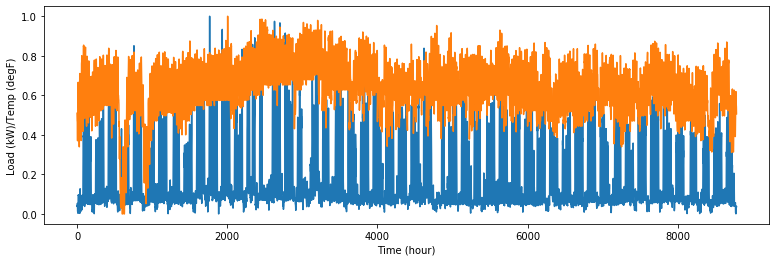

In [9]:
T1 = (T-T.min())/(T.max()-T.min())
Lt1  = (Lt-Lt.min())/(Lt.max()-Lt.min())
plt.figure(figsize=(13,4))
plt.plot(Lt1)
plt.plot(T1)
plt.ylabel('Load (kW)/Temp (degF)')
plt.xlabel('Time (hour)')

In [10]:
data = np.hstack((Lt1,T,W,H))
#data = np.hstack((Lt1,T))
data

array([[0.04069488, 0.50913838, 1.        , 0.        ],
       [0.03896727, 0.47519582, 1.        , 0.04347826],
       [0.0383914 , 0.47258486, 1.        , 0.08695652],
       ...,
       [0.0330166 , 0.54308094, 0.83333333, 0.91304348],
       [0.0330166 , 0.52219321, 0.83333333, 0.95652174],
       [0.03666379, 0.50652742, 0.83333333, 1.        ]])

### **b) Split into train vs test datasets**

In [12]:
dataL = Lt

# split into train and test sets
n = int(len(data)*0.8)
trainY, trainX = dataL[1:n], data[1:n]
testY, testX = dataL[n:len(data)], data[n:len(data)]


print(trainY.shape)
print(trainX.shape)
print('=====Lt=======Tt==========Lt+1====')
for i in range(5):
  print(trainX[i], trainY[i])


print(testY.shape)
print(testX.shape)
print('=====Lt=======Tt==========Lt+1====')
for i in range(5):
  print(testX[i,:], testY[i])


(7026, 1)
(7026, 4)
=====Lt=======Tt==========Lt+1====
[0.03896727 0.47519582 1.         0.04347826] [0.03896727]
[0.0383914  0.47258486 1.         0.08695652] [0.0383914]
[0.04203858 0.46997389 1.         0.13043478] [0.04203858]
[0.03666379 0.46475196 1.         0.17391304] [0.03666379]
[0.05336405 0.4308094  1.         0.2173913 ] [0.05336405]
(1757, 1)
(1757, 4)
=====Lt=======Tt==========Lt+1====
[0.05816297 0.63133159 0.33333333 0.82608696] [0.05816297]
[0.05585949 0.62663185 0.33333333 0.86956522] [0.05585949]
[0.0821576  0.62663185 0.33333333 0.91304348] [0.0821576]
[0.0816777  0.60052219 0.33333333 0.95652174] [0.0816777]
[0.07860639 0.60052219 0.33333333 1.        ] [0.07860639]


# **Step 3: Formulate ANN model**

In [13]:
from keras.optimizers import Adam
opt = Adam(lr=0.005)

model = Sequential()
model.add(Dense(6, activation='sigmoid', input_dim=4))#
model.add(Dense(6, activation='sigmoid'))#
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=opt)
history = model.fit(trainX, trainY, validation_split=0.1, epochs=100, batch_size=24, verbose=1)









Train on 6323 samples, validate on 703 samples
Epoch 1/100





6323/6323 [==============================] - 1s 154us/step - loss: 0.0376 - val_loss: 0.0217
Epoch 2/100
6323/6323 [==============================] - 0s 53us/step - loss: 0.0180 - val_loss: 0.0047
Epoch 3/100
6323/6323 [==============================] - 0s 51us/step - loss: 0.0023 - val_loss: 5.3966e-04
Epoch 4/100
6323/6323 [==============================] - 0s 49us/step - loss: 8.3911e-04 - val_loss: 4.4204e-04
Epoch 5/100
6323/6323 [==============================] - 0s 51us/step - loss: 7.1662e-04 - val_loss: 4.3707e-04
Epoch 6/100
6323/6323 [==============================] - 0s 51us/step - loss: 6.4363e-04 - val_loss: 3.7093e-04
Epoch 7/100
6323/6323 [==============================] - 0s 49us/step - loss: 5.8624e-04 - val_loss: 3.3639e-04
Epoch 8/100
6323/6323 [==============================] - 0s 49us/step - loss: 5.4507e-04 - val_loss: 3.3823e-04
Epoch 9/100
6323/6323 [==============================] - 0s 50us

In [14]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
None


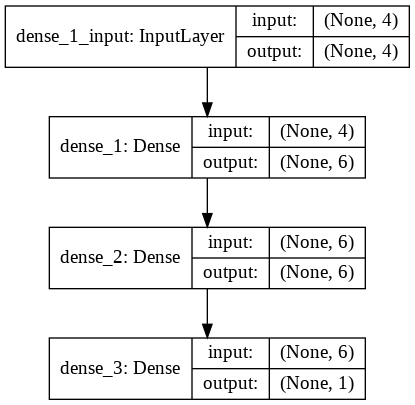

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# **Step 4: Predict and calculate RMSE**

In [0]:
testPredict1 = model.predict(testX)

testPredict1 = scaler.inverse_transform(testPredict1)
testY1       = scaler.inverse_transform(testY)    

RMSE1= 0.12438653775260267
MAPE1= 2.993445655841787


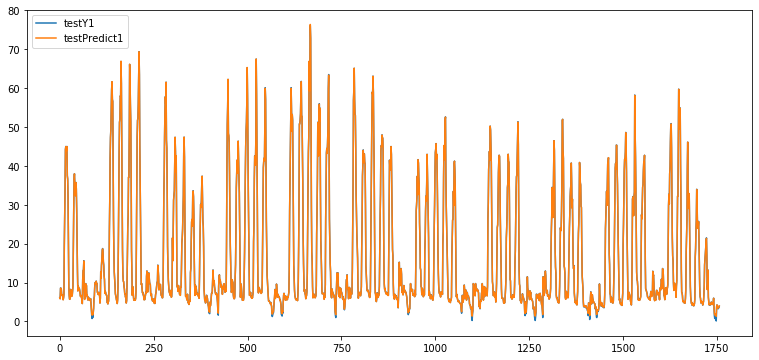

In [17]:
#plot testY vs testPredict
plt.figure(figsize=(13,6))
plt.plot(testY1, label='testY1')
plt.plot(testPredict1, label='testPredict1')
plt.legend(loc='upper left')

#calculate RMSE and MAPE
RMSE1 = np.sqrt(np.mean(np.square(testY1-testPredict1)))
MAPE1 = np.mean(np.abs((testY1-testPredict1)/testY1))*100
print('RMSE1=',RMSE1)
print('MAPE1=',MAPE1)

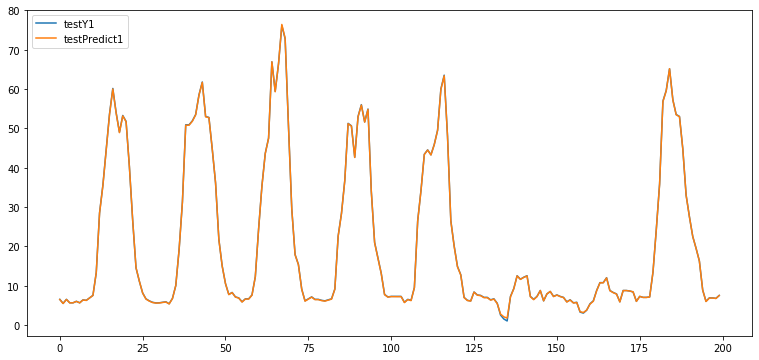

In [18]:
plt.figure(figsize=(13,6))
plt.plot(testY1[600:800], label='testY1')
plt.plot(testPredict1[600:800], label='testPredict1')
plt.legend(loc='upper left')

###**Step 5: Check model loss and validation loss**

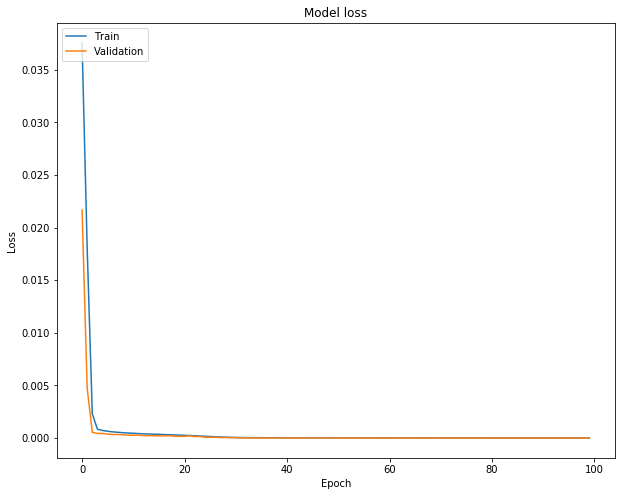

In [19]:
#Check model loss and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()